In [80]:
import numpy as np
# import torch 
# from torch.nn.parameter import Parameter
# from torch.nn import functional as F
# from torch.nn import init
# from torch.nn.module import Module
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn.modules.module import Module

In [3]:
tensor1 = torch.randn(3, 5, 4, 2)
print(list(tensor1.shape))
## test the transpose
b = tensor1.permute([1, 2, 0, 3])
b.shape

[3, 5, 4, 2]


torch.Size([5, 4, 3, 2])

In [82]:
tensor1 = torch.rand(5,1)
tensor2 =torch.rand(5, 1)

prod = tensor1.mul(tensor2)
prod.shape

torch.Size([5, 1])

In [83]:
scalarinput = torch.tensor([1])
scalarinput.shape

torch.Size([1])

In [85]:
vector = torch.randn(3, 10, 1)
weights = torch.randn(3, 10,1)
res = F.conv1d(vector, weights)
res.shape

torch.Size([3, 3, 1])

In [67]:
# define the TRL (tensor regression layer)
class TensorRegressionLayer:
    
    ## unfold:  X -> X(n) from tensor to matrix, n is the mode index
    @staticmethod
    def unfold(tensor, mode):
        shapelst = list(range(0, len(list(tensor.shape))))
        print("shape list is {}".format(shapelst))
        result = tensor.permute([mode] + shapelst[:mode] + shapelst[mode+1:])
        result = result.reshape(list(tensor.shape)[mode],-1)
        return result
    
    ## fold X(n) -> X from matrix to tensor, n is the mode index
    @staticmethod
    def fold(tensor, mode, shape):
        full_shape = list(shape)
        ## move the mode from original place on the top of the list
        mode_dim = full_shape.pop(mode)
#         print("after pop {}".format(full_shape))
        full_shape.insert(0, mode_dim)
#         print("full shape {}".format(full_shape))
        
        if None in full_shape:
            full_shape[full_shape.index(None)] = -1
            
        lst = list(range(1, len(full_shape)))
        lst.insert(mode, 0)
#         print("full shape {}".format(full_shape))
#         print("list {}".format(lst))
        result = tensor.view(full_shape)
        return result.permute(lst)
    
    ## tensor \times(n) matrix == matrix*tensor(n)[the mode n fiber of tensor]
    @staticmethod
    def mode_dot(tensor, matrix, mode):
        newshape = list(tensor.shape)
        if matrix.shape[1] != tensor.shape[mode]:
            raise ValueError("Shape error. {0}(matrix's 2nd dimension) is not as same as {1} (dimension of the tensor)".format\
                             (matrix.shape[1], tensor.shape[mode]))
        
        newshape[mode] = list(matrix.shape)[0]
#         print("tensor shape is {}".format(tensor.shape))

        unfoldtensor = TensorRegressionLayer.unfold(tensor, mode)
        res = matrix.matmul(TensorRegressionLayer.unfold(tensor, mode))
        return TensorRegressionLayer.fold(res, mode, newshape)
    
    ## core times a list of factors which is a list of Matrix
    @staticmethod 
    def tucker_to_tensor(core, factors):
        for i, factor in enumerate(factors):
            core = TensorRegressionLayer.mode_dot(core, factor, i)
            
        return core
        
    
    ## multiple cores:
    @staticmethod
    def tt_to_tensor(cores):
        tensor_size = []
        ## get the shape of a list of cores
        for c in cores:
            tensor_size.append(list(c.shape)[1])
        md = 2
        newshape = list(cores[0].shape)[:-1] + list(cores[1])[1:]
        t = TensorRegressionLayer.mode_dot(cores[0], TensorRegressionLayer.unfold(cores[1], 0), md)
        t = t.reshape(newshape)
        
        for i in range(1, len(tensor_size)-1):
            md = md+1
            newshape = list(t.shape)[:-1] + list(cores[i+1].shape)[1:]
            t = TensorRegressionLayer.mode_dot(t, TensorRegressionLayer.unfold(cores[i+1], 0), md)
            t = t.reshape(t, newshape)
            
        return t.reshape(tensor_size)
    
    ## cp decomposition low rank of tensors with element dimension of  B_D:  dim D * r 
    ## r is the rank, 
    ## ranktensors: row index means the rank num, colums means the decomposed vectors
    @staticmethod
    def cp_to_tensor(rankrtensors):
        
        tsnr = rankrtensors[0][0]
        newshape = []
        newshape.append(tsnr.reshape([-1, 1]).shape[0])
        for i in range(1, len(rankrtensors[0])):
            tsnr = torch.mul(tsnr.reshape([-1, 1]), rankrtensors[0][i].reshape([1, -1]))
            newshape.append(tsnr.shape[1])
        ## if rank 1 approximation
        if len(rankrtensors) == 1:
            return (tsnr.reshape(newshape))
        
        for j in range(1, len(rankrtensors)):
            t = rankrtensors[j][0]
            for k in range(1,len(rankrtensors[j])):
                t = torch.mul(t.reshape([-1, 1]), rankrtensors[j][k].reshape([1, -1]))
                
            tsnr = torch.add(tsnr, t)
        
        tsnr = tsnr.reshape(newshape)
        return tsnr

        
   
    # NUMPY
    @staticmethod
    def np_unfold(tensor, mode):
        return np.moveaxis(tensor, mode, 0).reshape((tensor.shape[mode], -1))


    @staticmethod
    def np_fold(unfolded_tensor, mode, shape):
        full_shape = list(shape)
        mode_dim = full_shape.pop(mode)
        full_shape.insert(0, mode_dim)
        return np.moveaxis(unfolded_tensor.reshape(full_shape), 0, mode)

    @staticmethod
    def np_mode_dot(tensor, matrix, mode):
        new_shape = list(tensor.shape)

        if matrix.ndim == 2:  # Tensor times matrix
            # Test for the validity of the operation
            if matrix.shape[1] != tensor.shape[mode]:
                raise ValueError(
                    'shapes {0} and {1} not aligned in mode-{2} multiplication: {3} (mode {2}) != {4} (dim 1 of matrix)'.format(
                        tensor.shape, matrix.shape, mode, tensor.shape[mode], matrix.shape[1]
                    ))
            new_shape[mode] = matrix.shape[0]

        res = np.dot(matrix, TNSR.np_unfold(tensor, mode))

        return TNSR.np_fold(res, mode, new_shape)
    
    
    


In [68]:
TRL = TensorRegressionLayer
## test unfold
c = TRL.unfold(tensor1, 3)
c.shape

shape list is [0, 1, 2, 3]


torch.Size([2, 60])

In [30]:
## test fold
d = TRL.fold(c, 3, [5, 4, 3, 2])
d.shape

after pop [5, 4, 3]
full shape [2, 5, 4, 3]
list [1, 2, 3, 0]


torch.Size([5, 4, 3, 2])

In [31]:
## test mode_dot
matrix =  torch.randn(10, 4)
res = TRL.mode_dot(d, matrix, 1)
res.shape


tensor shape is torch.Size([5, 4, 3, 2])
shape list is [0, 1, 2, 3]
shape list is [0, 1, 2, 3]
after pop [5, 3, 2]
full shape [10, 5, 3, 2]
list [1, 0, 2, 3]


torch.Size([5, 10, 3, 2])

In [37]:
## test tucker_to_tensor
factor1 = torch.randn(10, 5)
factor2 = torch.randn(15, 4)
factor3 = torch.randn(20, 3)
factor4 = torch.randn(25, 2)
factors =  [factor1, factor2, factor3, factor4] 
res = TRL.tucker_to_tensor(d, factors)
res.shape


tensor shape is torch.Size([5, 4, 3, 2])
shape list is [0, 1, 2, 3]
shape list is [0, 1, 2, 3]
after pop [4, 3, 2]
full shape [10, 4, 3, 2]
list [0, 1, 2, 3]
tensor shape is torch.Size([10, 4, 3, 2])
shape list is [0, 1, 2, 3]
shape list is [0, 1, 2, 3]
after pop [10, 3, 2]
full shape [15, 10, 3, 2]
list [1, 0, 2, 3]
tensor shape is torch.Size([10, 15, 3, 2])
shape list is [0, 1, 2, 3]
shape list is [0, 1, 2, 3]
after pop [10, 15, 2]
full shape [20, 10, 15, 2]
list [1, 2, 0, 3]
tensor shape is torch.Size([10, 15, 20, 2])
shape list is [0, 1, 2, 3]
shape list is [0, 1, 2, 3]
after pop [10, 15, 20]
full shape [25, 10, 15, 20]
list [1, 2, 3, 0]


torch.Size([10, 15, 20, 25])

In [49]:
## test the torch.mul
a = torch.rand(10, 1)
b = torch.rand(5, 1)
d = torch.rand(6, 1)

c = torch.mul(a.view([-1, 1]), b.permute([1,0]))
print(c.shape)
c = c.view([-1, 1])
print("view c {}".format(c.shape))
c =  torch.mul(c.view([-1, 1]), d.permute([1,0]))
c.shape
c = c.reshape([10, 5, 6])
c.shape

torch.Size([10, 5])
view c torch.Size([50, 1])


torch.Size([10, 5, 6])

In [69]:
a1 = torch.rand(10, 1)
b1 = torch.rand(5, 1)
d1 = torch.rand(6, 1)

a2 = torch.rand(10, 1)
b2 = torch.rand(5, 1)
d2 = torch.rand(6, 1)

lst = [[a1,b1,d1], [a2,b2,d2]]
print(len(lst), len(lst[0]), lst[0][1])
res = TRL.cp_to_tensor(lst)
res.shape

2 3 tensor([[0.8084],
        [0.4925],
        [0.8658],
        [0.4408],
        [0.0052]])


torch.Size([10, 5, 6])

In [81]:
## create an empty tensor then initialize it in a specific way
testtensor = torch.empty(size = [3,4,5])
testtensor = init.xavier_normal_(testtensor)
testtensor.shape

torch.Size([3, 4, 5])

In [88]:
## test F.linear for covariate
inputt = torch.rand(1, 10)
weightt = torch.rand(20, 10)
res = F.linear(inputt, weightt)
res.shape

torch.Size([1, 20])

In [93]:
## test F.linear for tensors
inputt = torch.rand(10 , 30)
weightt = torch.rand(10, 30)
res = torch.mul(inputt.view(-1 ,300), weightt.view(-1, 300))
res.shape
res = res.reshape([-1, 10, 30])
res.shape

torch.Size([1, 10, 30])

In [ ]:
from torch.nn.parameter import Parameter
from .. import functional as F
from .. import init
from .module import Module


## Inherit from Function
class TRL(Module)
    """
    Tucker regression layer(trl)
    Args:
        input_tsr: the input tensor
        rank: hyperparameter. Must be a list that specifies the Tucker rank of the regression tensor W.
        output_tns: output tensor size


    """
    __constants__ = ['input_tns', 'output_tns', 'ranks', 'bias']

    
    def __init__(self, input_tns, output_tns, ranks, bias=True):
        super(TRL, self).__init__()
        self.input_shape = list(input_tns.shape)
        self.input = input_tns
        self.output = output_tns
        ## initialize the cores
        self.cores = Parameter(torch.empty(ranks))
        
        ## initialize the factors
        self.factors = [Parameter(torch.empty(self.input_shape[i], ranks[i]))
                            for i in range(len(self.input_shape))]
        if bias:
            self.bias = Parameter(torch.empty(size=[1, output_tns]))
        else:
            self.register_parameter('bias', None)

        self.factors.append(Parameter(init.xavier_normal_(size=(n_outputs, ranks[-1]))))
            
        self.reset_parameters()
        
        
    def reset_parameters():
        init.xavier_uniform_(self.cores)
        for i in range(len(self.factors)):
            init.xavier_uniform_(self.factors[i])
            
        if self.bias is not None:
            init.xavier_uniform_(sefl.bias)
                
    #forward function, bias is optional
    def forward(self, input):
        regression_weights = TNSR.tucker_to_tensor(core, factors)
        x_0 = input.reshape([-1, np.prod(self.input_shape)])
        w_minus1 = tf.reshape(regression_weights, [np.prod(self.input_shape),n_outputs])
        if self.bias is not None:
            return tf.add(tf.matmul(x_0, w_minus1) ,bias)
        
        else:
            return tf.add(tf.malmul(x0, w_minus1))

In [96]:
## test on the parameter shape
tensor = torch.empty([5, 10]+[15])
tensor.shape


torch.Size([5, 10, 15])

In [392]:
## the class for Vector version
import math

class VecTRL(Module):
    """
    The degressed version of Tucker innerproduct regression layer, 
                                 regression
    vector variables + covariates --- > a vector
    
    Args: 
    intput_shape: a list of vectors size [p1, p2, ... pd]
    inputcovariate: number of covariate [m]
    outputtensor: the size of output tensor(vector), here must be a list format [n]
    bias: whether use bias
    Pay attention here!!!!!!!!!!!!!
    We implement the tensor ---> tensor regression!! we need to flatten the matrix 
    to a lonnnng vector to call F.linear
    
    """
    
    __constants__=['inputtensor', 'inputcovariate', 'outputtensor', 'bias']
    
    def __init__(self, input_shape, inputcovariate, outputtensor, bias=True):
        super(VecTRL, self).__init__()

        self.input_shape = input_shape
        ## we just use the one dimension
        self.covar_shape = inputcovariate[0]
        ## we just use the one dimension for vector
        self.output_shape = outputtensor[0]
        
        # Wtensor is the weighting list for a list of weighting for different input vectors
        self.Wtensor = [Parameter(torch.empty(self.output_shape, self.input_shape[i]))
                            for i in range(len(self.input_shape))]
        self.Wcovar = Parameter(torch.empty(self.output_shape, self.covar_shape))
        
        if bias:
            self.bias = Parameter(torch.empty(self.output_shape))
        else:
            self.register_parameter('bias', None)
            
        self.reset_parameters()
        
        
    def reset_parameters(self):
        
        
        for i in range(len(self.input_shape)):
            
            init.xavier_uniform_(self.Wtensor[i])
        
        init.kaiming_uniform_(self.Wcovar, a=math.sqrt(5))        
        
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.Wcovar)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
            
       
            
    def forward(self, tensors, covariate):
        covtensor = F.linear(covariate, self.Wcovar)
#         print("tensors number {}".format(len(self.input_shape)))
#         print("tensors shape {}".format(tensors.shape))
        for i in range(len(self.input_shape)):
#             print(tensors.shape)
            covtensor += F.linear(tensors[..., i, :], self.Wtensor[i])
            
            
        covtensor += self.bias
        
        return covtensor
        
            
    
    

In [414]:
### simulation on vectors-vectors regression
input_shape = [2]
convariate_shape = [2]
output_shape = [2]
learning_rate = 0.01
model = VecTRL(input_shape, convariate_shape,output_shape)
learning_rate = 0.01

In [415]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [395]:
import numpy as np

sample_size = 1000
output_tensor = []
output_mu = [0, 0]
output_cov = [[1, 0], [0, 1]]
output = np.random.multivariate_normal(output_mu, output_cov, (sample_size))
print(output.shape)    
print(output[2, :])

(1000, 2)
[-0.23542834  0.60453927]


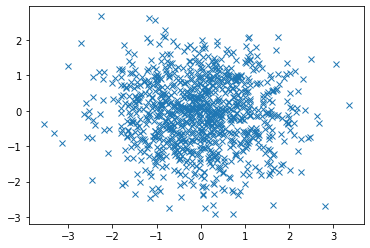

In [396]:
import matplotlib.pyplot as plt

plt.plot(output[:, 0].T, output[:, 1].T, 'x')
plt.show()

(1000, 2)
[ 0.68815857 -0.67752345]


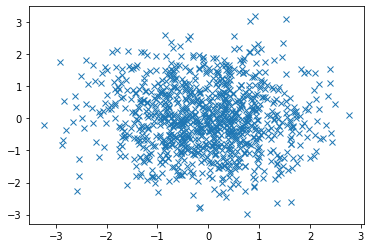

In [397]:
input1_mu = [0, 0]
input1_cov = [[1, 0], [0, 1]]
input1 = np.random.multivariate_normal(input1_mu, input1_cov, (sample_size))
print(input1.shape)    
print(input1[2, :])
plt.plot(input1[:, 0].T, input1[:, 1].T, 'x')
plt.show()

(1000, 2)
[-1.55107099  4.29878775]


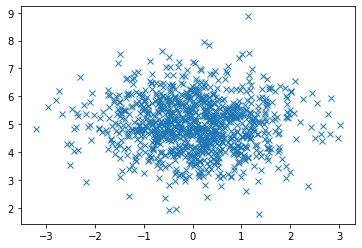

In [398]:
input2_mu = [0, 5]
input2_cov = [[1, 0], [0, 1]]
input2 = np.random.multivariate_normal(input2_mu, input2_cov, (sample_size))
print(input2.shape)    
print(input2[2, :])
plt.plot(input2[:, 0].T, input2[:, 1].T, 'x')
plt.show()

(1000, 2)
[4.13542008 3.86150883]


/Users/ham112/opt/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


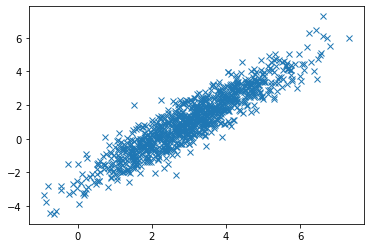

In [399]:
input3_mu = [3, 1]
input3_cov = [[1, 1], [3, 4]]
input3 = np.random.multivariate_normal(input3_mu, input3_cov, (sample_size))
print(input3.shape)    
print(input3[2, :])
plt.plot(input3[:, 0].T, input3[:, 1].T, 'x')
plt.show()

In [400]:
covariate = []
mu= [0, 0]
sigma= [0, 0]
for i in range(convariate_shape[0]):
    s = np.random.normal(mu[i], sigma[i], 1000)
    covariate.append(s)
    

In [406]:
## formalize the numpy input
### formalize the tensors
input_tensors = np.array([output], dtype='float')
print("input_tensor shape is: {}".format(input_tensors.shape))
input_tensors = np.transpose(input_tensors, (1,0,2))
print("tensor shape is {}".format(input_tensors.shape))

### formalize the covariate
input_covar = np.array(covariate, dtype='float')

### formalize the output
output_tensor = output




input_tensor shape is: (1, 1000, 2)
tensor shape is (1000, 1, 2)


In [402]:
## Model settings
batch_size = 4
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [403]:
for x in model.Wcovar:
    print(x)
    print(torch.norm(x,1))
    
flatten = torch.cat([x.view(-1) for x in model.Wcovar])
flatten

tensor([-0.1981,  0.0908], grad_fn=<SelectBackward>)
tensor(0.2888, grad_fn=<NormBackward0>)
tensor([ 0.3980, -0.6504], grad_fn=<SelectBackward>)
tensor(1.0484, grad_fn=<NormBackward0>)


tensor([-0.1981,  0.0908,  0.3980, -0.6504], grad_fn=<CatBackward>)

In [404]:
for x in model.Wtensor:
    print(x.shape)
    print(x)
    print(torch.norm(x,1))

flatten = torch.cat([x.view(-1) for x in model.Wtensor])
flatten

torch.Size([2, 2])
Parameter containing:
tensor([[0.6186, 0.3068],
        [1.1659, 0.5330]], requires_grad=True)
tensor(2.6243, grad_fn=<NormBackward0>)


tensor([0.6186, 0.3068, 1.1659, 0.5330], grad_fn=<CatBackward>)

In [405]:
## formalize the numpy input
### formalize the tensors
input_tensors = np.array([input1, input2, input3], dtype='float')
print("input_tensor shape is: {}".format(input_tensors.shape))
input_tensors = np.transpose(input_tensors, (1,0,2))
print("tensor shape is {}".format(input_tensors.shape))

### formalize the covariate
input_covar = np.array(covariate, dtype='float')
input_covar = np.transpose(input_covar, (1,0))

### formalize the output
output_tensor = output


input_tensor shape is: (3, 1000, 2)
tensor shape is (1000, 3, 2)


In [407]:
## normalize the data
def normalize(x):
    maxx =  x.max(0, keepdim=True).values
    mean =  x.mean(0, keepdim=True)
    std = x.std(0, keepdim=True)
#     print(mean, std)
    x_normed = x - mean / std
    return x_normed

# print(input_covar)
print(normalize(torch.tensor(input_covar)).shape)

print()
# print(input_tensors)
print(normalize(torch.tensor(input_tensors)).shape)





tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [408]:
input_covars = normalize(torch.tensor(input_covars))
input_tensors = normalize(torch.tensor(input_tensors))

tensor([[-1.3178,  3.9580]]) tensor([[3.0069, 5.9706]])
tensor([[[-0.0432, -0.0860]]], dtype=torch.float64) tensor([[[1.0402, 0.9842]]], dtype=torch.float64)


/Users/ham112/opt/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [356]:
def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed


t = torch.tensor([[1000, 10, 0.5], [765, 5, 0.35], [800, 7, 0.09]])
print("t shape is {}".(t.shape))
print(normalize(t))


SyntaxError: invalid syntax (<ipython-input-356-df705d9f41c5>, line 7)

In [416]:
lambda1 = 0
epochs = 1
from torch.autograd import Variable


input_tensors = Variable(input_tensors.float())
input_covars = Variable(input_covars.float())       
output_tensors = Variable(torch.from_numpy(output).float())



print("input tensor type {}".format(input_tensors.shape))
print("input covar type {}".format(input_covars.shape))
print("output tensors type {}".format(output_tensors.shape))


losses = []

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    
#     input_tensors = Variable(torch.from_numpy(input_tensors))
#     input_covars = Variable(torch.from_numpy(input_covar))       
#     output_tensors = Variable(torch.from_numpy(output))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    print("input_tensors shape {}".format(input_tensors.shape))
    outputs = model(input_tensors,input_covars)

    # get loss for the predicted output
    loss = criterion(outputs, output_tensors)
    
    ## add regularization
    all_linear_cov_params = torch.cat([x.view(-1) for x in model.Wcovar])
    all_linear_tensor_params = torch.cat([x.view(-1) for x in model.Wtensor])
    
    l1_tensor_regularization = lambda1 * torch.norm(all_linear_tensor_params, 1)
    l1_covar_regularization = lambda1 * torch.norm(all_linear_cov_params, 1)
    
    loss = loss + l1_tensor_regularization + l1_covar_regularization
    losses.append(loss)

    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

input tensor type torch.Size([1000, 1, 2])
input covar type torch.Size([1000, 2])
output tensors type torch.Size([1000, 2])
input_tensors shape torch.Size([1000, 1, 2])
tensor(16.6724, grad_fn=<AddBackward0>)
epoch 0, loss 16.672378540039062


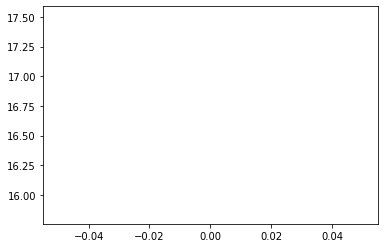

In [417]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses)

In [418]:
model.Wcovar

Parameter containing:
tensor([[ 0.2195,  0.3629],
        [-0.4152,  0.1996]], requires_grad=True)

In [419]:
model.Wtensor

[Parameter containing:
 tensor([[ 0.6094,  0.4551],
         [ 0.9162, -0.6507]], requires_grad=True)]

In [413]:
a = np.matmul(output.T, output)
print(a.shape)
b = np.matmul(a.T, a)
b

(2, 2)


array([[1173614.98705122,  -64804.73589067],
       [ -64804.73589067,  951855.22363061]])